# `ipython-gremlin`

In [1]:
%reload_ext gremlin
%matplotlib inline
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from draw_graph import draw_simple_graph  # A utility function that uses NetworkX plotting API

#### Load up the Grateful Dead data into an instance of TinkerGraph

In [2]:
dir_path = os.path.dirname(os.path.realpath('__file__'))
file_path = os.path.join(dir_path, 'grateful-dead.xml')
%gremlin graph.io(graphml()).readGraph(file_path)

Alias-- localhost --created for database at ws://localhost:8182/gremlin


[]

#### Get some basic stats

In [3]:
num_verts = %gremlin g.V().count()
num_verts

808

In [4]:
%gremlin g.E().count()

8049

#### Get the degree distribution

In [5]:
deg_dist = %gremlin g.V().groupCount().by(both().count())

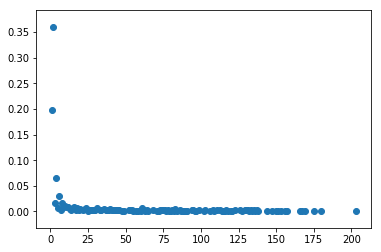

In [6]:
degree = map(lambda x: int(x), deg_dist.results.keys())
prob = map(lambda x: x / num_verts.results, deg_dist.results.values())
plt.scatter(list(degree), list(prob))

#### Count vertex labels

In [7]:
label_count = %gremlin g.V().label().groupCount()

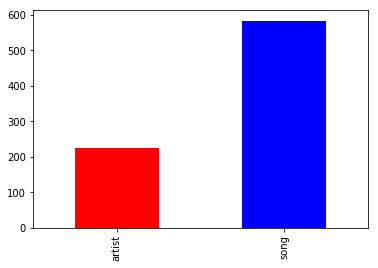

In [8]:
label_count.dataframe.plot(kind='bar', color=['r', 'b'])

#### Count edge labels

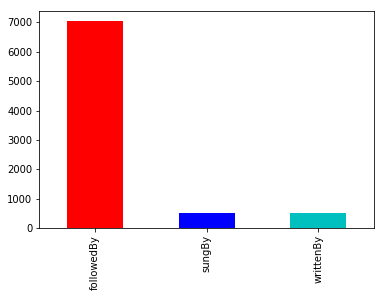

In [9]:
label_count = %gremlin g.E().label().groupCount()
label_count.dataframe.plot(kind='bar', color=['r', 'b', 'c'])

#### Find the most prolific artist

In [10]:
artist = %gremlin g.V().hasLabel('artist').order().by(inE().count(), decr).limit(1)
vid = artist.results.id

In [11]:
%gremlin g.V(vid).valueMap(true)

{'id': 340, 'label': 'artist', 'name': ['Garcia']}

In [12]:
%gremlin g.V(vid).inE().count()

150

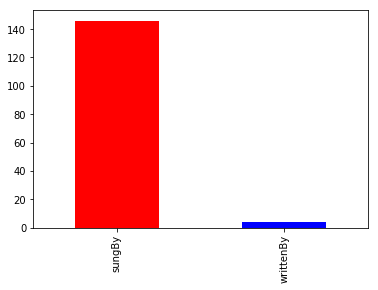

In [13]:
jerrys_labels = %gremlin g.V(vid).inE().groupCount().by(T.label)
jerrys_labels.dataframe.plot(kind='bar', color=['r', 'b'])

#### Get Jerry's ego network

In [14]:
jerrys_ego_net = %gremlin g.V(vid).bothE()

In [15]:
graph = jerrys_ego_net.graph
print(len(graph.nodes()), len(graph.edges()))

149 150


In [16]:
nodes = graph.nodes()
names = %gremlin g.V(nodes).properties('name')
labels = %gremlin g.V(nodes).label()

In [17]:
# Add names/labels to nodes
name_map = {}
label_map = {}
for i in range(len(nodes)):
    name_map[nodes[i]] = names[i].value
    label_map[nodes[i]] = labels[i]
nx.set_node_attributes(graph, 'name', name_map)
nx.set_node_attributes(graph, 'label', label_map)

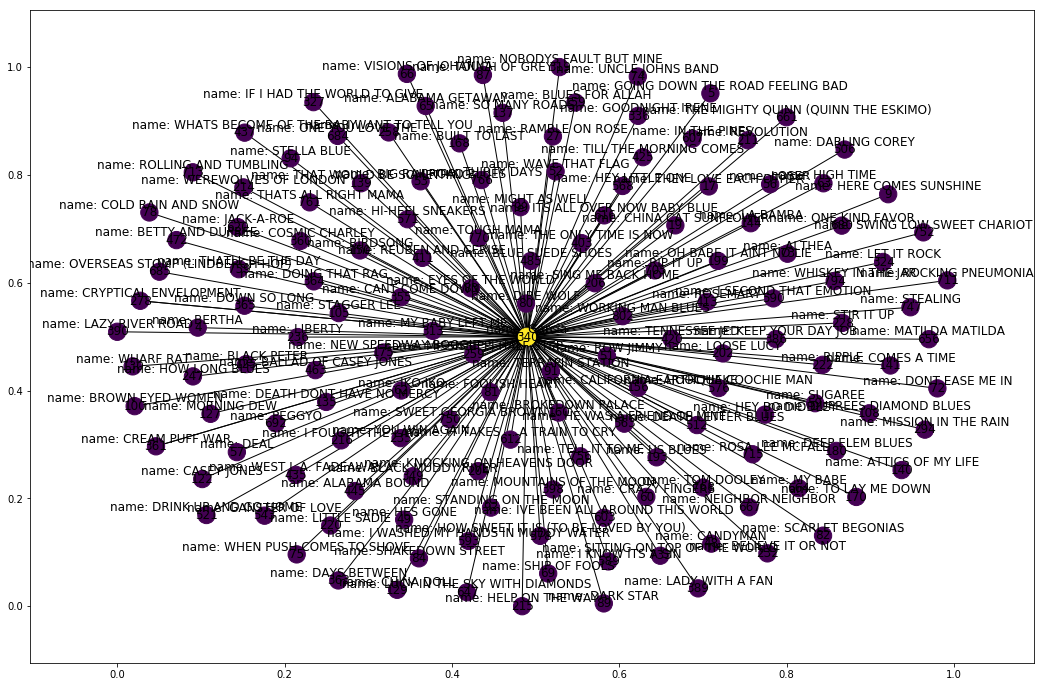

In [18]:
plt.rcParams['figure.figsize'] = (18, 12)
draw_simple_graph(graph,
                  node_type_attr='label',
                  edge_label_attr='',
                  show_edge_labels=False,
                  label_attrs=['name'],
                  k=0.005)

#### That's a lot of vertices for matplotlib...maybe `ipython-gremlin` needs a D3 interface...

#### Run some graph algos using NetworkX

In [19]:
edges = %gremlin g.E()

In [20]:
full_graph = edges.graph
print(len(full_graph.nodes()), len(full_graph.edges()))

808 8049


In [21]:
bc = nx.betweenness_centrality(full_graph)
cc = nx.closeness_centrality(full_graph)
dc = nx.degree_centrality(full_graph)

In [22]:
cent_df = pd.DataFrame({'closeness': cc, 'betweenness': bc, 'degree': dc})
cent_df.describe()

,betweenness,closeness,degree
count,808.000000,808.000000,808.000000
mean,0.000554,0.083770,0.024688
std,0.001468,0.099867,0.045461
min,0.000000,0.000000,0.001239
25%,0.000000,0.000000,0.002478
50%,0.000000,0.002478,0.002478
75%,0.000500,0.192108,0.019827
max,0.018547,0.264199,0.251549


#### Check out the [Official Documentation](http://ipython-gremlin.readthedocs.io/en/latest/)